<font size="6"> **Analyze SEC 10-K Fillings** </font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../nb_config.py

In [3]:
import nltk
import numpy as np
import pandas as pd
import scipy
import pickle
import pprint

import os

from tqdm import tqdm

In [4]:
from src import utils
from src.load_data import load_sec10k, io_utils
from src.nlp_quant import bow_sent

In [5]:
cfg = utils.read_conf()

In [6]:
INPATH1 = os.path.join(io_utils.interim_path, 'sec_10k', '')
INPATH2 = os.path.join(io_utils.raw_path, 'market_data', cfg['quantopian']['dataset4']['folder'],'')
os.path.isdir(INPATH1), os.path.isdir(INPATH2)

(True, True)

In [7]:
INFILE1 = 'metadata.pkl'
INFILE2 = 'sec_10k.pkl'
INFILE3 =  'parsed_sentiment_loughran_mcdonald.csv'
INFILE4 = cfg['quantopian']['dataset4']['prices']

In [8]:
OUTPATH =  os.path.join(io_utils.processed_path, 'sec_10k', '')
os.path.isdir(OUTPATH)

True

In [9]:
OUTFILE1 = 'sec_10k_loughran_cos_similarities.csv'
OUTFILE2 = 'sec_10k_loughran_sent_scores.csv'

# Load SEC 10-K Processed fillings

In [10]:
with open(INPATH1 + INFILE1, 'rb') as file:
    metadata = pickle.load(file)

In [11]:
with open(INPATH1 + INFILE2, 'rb') as file:
    ten_ks_by_ticker = pickle.load(file)

In [12]:
example_ticker = 'AMZN'

In [13]:
file_dates = metadata['file_dates']

In [14]:
sentiment_df =  pd.read_csv(INPATH1 + INFILE3)

In [15]:
# Yearly pricing
pricing = pd.read_csv(INPATH2 + INFILE4, parse_dates=['date'])
pricing = pricing.pivot(index='date', columns='ticker', values='adj_close')
pricing.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 1962-01-01 to 2018-01-01
Columns: 11941 entries, A to ZZZ
dtypes: float64(11941)
memory usage: 5.2 MB


In [16]:
pd.concat([pricing.head(2), pricing.tail(2)], axis=0)

ticker,A,AA,AAAP,AABA,AAC,AADR,AAIT,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,AAPC,AAPL,AAT,AAU,AAV,AAVL,AAWW,AAXJ,AAXN,AA_P_B,AA_W,...,ZOES,ZOM,ZOOM,ZPIN,ZQK,ZROZ,ZS,ZSAN,ZSL,ZSML,ZSPH,ZTO,ZTR,ZTS,ZU,ZUMZ,ZUO,ZVZZC,ZVZZCNX,ZX,ZXYZ_A,ZYME,ZYNE,ZZK,ZZZ
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1962-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,66.653918,53.87,81.62,69.85,9.00,58.835707,NaN,51.803585,81.6,3.378882,39.797356,37.82,36.522919,99.593649,10.6,167.90118,37.654925,1.03,4.3,NaN,58.65,75.858764,26.50,NaN,NaN,...,16.72,1.9771,NaN,18.2,NaN,120.593382,NaN,10.40,31.40,26.9,NaN,15.641173,12.643875,71.815333,NaN,20.825,NaN,100.1,NaN,1.2165,NaN,7.5931,12.52,25.0,0.01
2018-01-01,61.800000,46.88,81.63,73.35,9.81,52.880000,NaN,37.990000,67.9,2.575000,43.740000,46.00,35.250000,135.860000,NaN,185.40000,38.860000,0.71,3.1,NaN,71.45,70.250000,64.98,NaN,NaN,...,10.16,2.2100,NaN,NaN,NaN,115.750000,36.67,4.68,34.91,NaN,NaN,19.450000,11.450000,86.150000,NaN,24.300,26.74,NaN,NaN,1.3800,NaN,15.3400,9.17,NaN,NaN


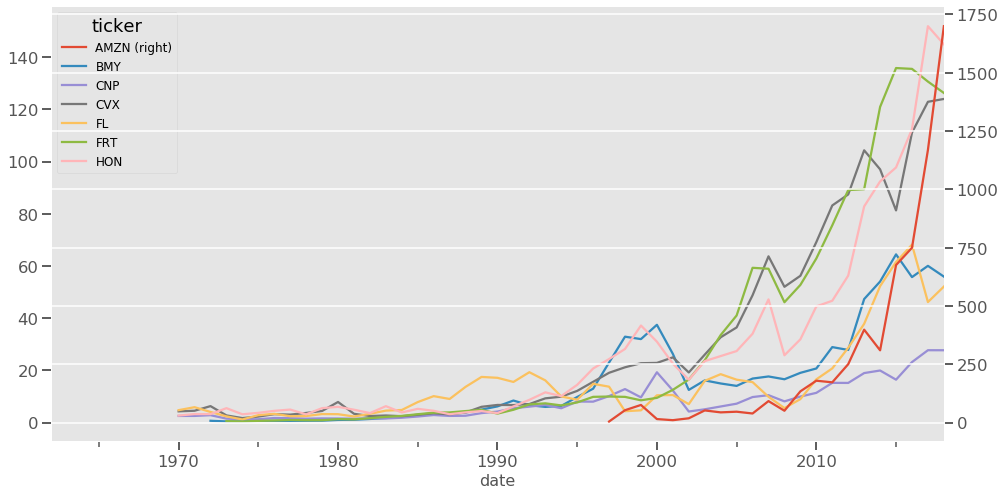

In [17]:
pricing[list(metadata['tickers'].keys())].plot(secondary_y=example_ticker)
plt.show()

# Rule Based Sentiment Analysis: Loughran Mcdonald textual analysis in financial data

Leverage expert crafted sentiments word lists to analyze create alpha factors. Two approaches:

* For a given ticker's 10k's document, measure evolution at each sentiment by computing similiarity among doc[t] and doc[t+1]
* Compute a sentiment score based on frequencies of each sentiment word list on each ticker 10k. Then standardize scores to obtain an alpha factor by each document



Referene: https://sraf.nd.edu/textual-analysis/resources/

In [18]:
ten_ks_by_ticker['AMZN'][0].keys()

dict_keys(['cik', 'file', 'file_date', 'file_clean', 'file_lemma'])

In [19]:
sentiment_df.columns

Index(['negative', 'positive', 'uncertainty', 'litigious', 'constraining',
       'interesting', 'word'],
      dtype='object')

In [20]:
sentiments = sentiment_df.columns.tolist()[:-1]
sentiments

['negative',
 'positive',
 'uncertainty',
 'litigious',
 'constraining',
 'interesting']

In [21]:
ten_ks_by_ticker[example_ticker][0]['file_date'], ten_ks_by_ticker[example_ticker][-1]['file_date']

('2017-02-10', '1999-03-05')

In [22]:
file_dates[example_ticker][0], file_dates[example_ticker][-1]

('2017-02-10', '1999-03-05')

## BoW and TF-IDF Representations by Sentiment

In [23]:
sentiment_bow_ten_ks = {}
sentiment_tfidf_ten_ks = {}
doc_len = {}
for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    sentiment_bow_ten_ks[ticker] = {}
    sentiment_tfidf_ten_ks[ticker] = {}
    idx_dates = file_dates[ticker]
    for sentiment in sentiments:
        # Vocabulary
        sentiment_vocab = sentiment_df[sentiment_df[sentiment]]['word']
        sentiment_vocab_bool = sentiment_df.set_index('word')[sentiment]
        sentiment_vocab_vec = sentiment_vocab_bool[sentiment_vocab_bool].astype(int)
        
        # Matrix representations
        sentiment_bow_ten_ks[ticker][sentiment] = pd.DataFrame(
            index=idx_dates, data=bow_sent.get_bag_of_words(sentiment_vocab, lemma_docs), columns=sentiment_vocab)
        sentiment_tfidf_ten_ks[ticker][sentiment] = pd.DataFrame(
            index=idx_dates, data=bow_sent.get_tfidf(sentiment_vocab, lemma_docs), columns=sentiment_vocab)
        

In [24]:
sentiment_tfidf_ten_ks['AMZN']['negative'].head(2)

word,abandon,abandonment,abandonments,abdicate,abdication,abdications,aberrant,aberration,aberrational,aberrations,abet,abnormal,abnormalities,abnormality,abnormally,abolish,abrogate,abrogation,abrogations,abrupt,abruptly,abruptness,absence,absences,absenteeism,...,waste,wasteful,weak,weaken,weaker,weakest,weakly,weakness,weaknesses,willfully,worry,worse,worsen,worst,worthless,writedown,writedowns,writeoff,writeoffs,wrong,wrongdoing,wrongdoings,wrongful,wrongfully,wrongly
2017-02-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.011790,0.0,0.0,0.015567,0.0,0.0,0.0,0.008713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080973,0.0,0.0,0.0,0.0
2016-01-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015746,0.0,0.0,...,0.011688,0.0,0.0,0.015432,0.0,0.0,0.0,0.008638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094870,0.0,0.0,0.0,0.0


## Sentiment Scores

Firstly, aggregate tf-idf scores for each doc-sentiment (on each date). As sentiment vocabulary is considerabily varies, perform a zscore on date axis, that's it, by aggregating on each date each sentiment score

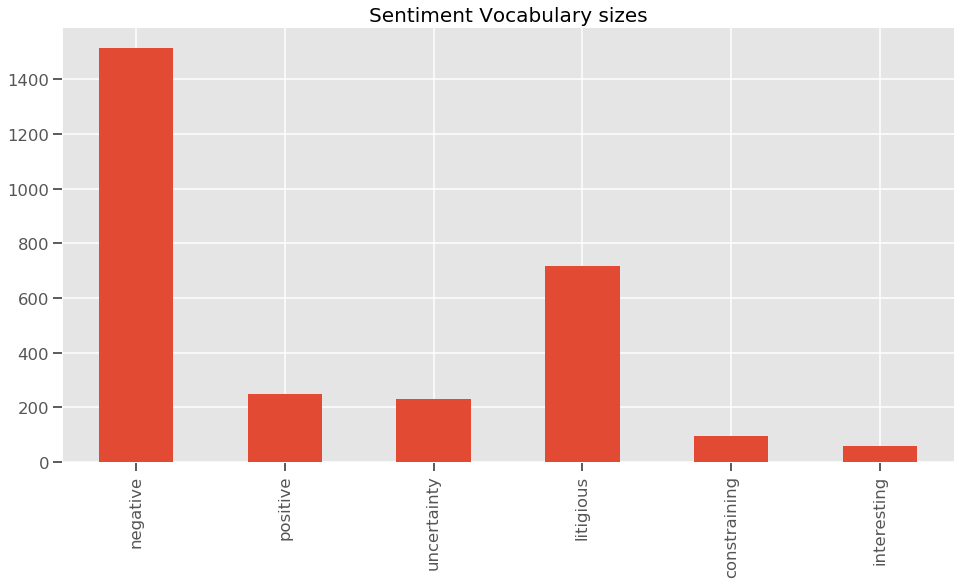

In [25]:
sent_vocab_sizes = sentiment_df[sentiments].sum(axis=0)
sent_vocab_sizes.plot.bar(title='Sentiment Vocabulary sizes')
plt.show()

In [26]:
sent_score_dfs =  {}
sent_vocab_sizes = pd.Series(index=sentiments, dtype=float)

for ticker, ten_ks_mats in sentiment_tfidf_ten_ks.items():
    df_index = pd.DatetimeIndex(file_dates[ticker])
    df = pd.DataFrame(index=df_index, columns=sentiments, dtype=float)
    for sentiment in sentiments:
        sent_raw_score = ten_ks_mats[sentiment].sum(axis=1)
        df[sentiment] = sent_raw_score
        n_tokens_sent = ten_ks_mats[sentiment].shape[1]

    sent_score_dfs[ticker]  = df

In [27]:
sent_alphas_raw = pd.concat(sent_score_dfs)
sent_alphas_raw.index.names = ['ticker', 'date']
sent_alphas_raw['idx_year'] = sent_alphas_raw.index.get_level_values('date').year
sent_alphas_raw.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 131 entries, ('AMZN', Timestamp('2017-02-10 00:00:00')) to ('HON', Timestamp('1995-03-02 00:00:00'))
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   negative      131 non-null    float64
 1   positive      131 non-null    float64
 2   uncertainty   131 non-null    float64
 3   litigious     131 non-null    float64
 4   constraining  131 non-null    float64
 5   interesting   131 non-null    float64
 6   idx_year      131 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 13.5+ KB


In [28]:
pd.concat([sent_alphas_raw.head(2), sent_alphas_raw.tail(2)], axis=0)

negative  positive  uncertainty  litigious  constraining  \
ticker date                                                                   
AMZN   2017-02-10  6.343634  4.283349     2.852306   4.738780      3.103954   
       2016-01-29  6.293106  4.533542     2.866446   4.672675      3.151264   
HON    1996-02-27  5.056922  3.698546     3.020554   2.614288      2.353870   
       1995-03-02  5.236017  4.152916     2.923928   2.599948      2.310896   

                   interesting  idx_year  
ticker date                               
AMZN   2017-02-10     1.350747      2017  
       2016-01-29     1.347868      2016  
HON    1996-02-27     1.453995      1996  
       1995-03-02     1.334356      1995

In [29]:
sent_alphas_count = sent_alphas_raw.groupby('idx_year').size()
sent_alphas_count.name = 'count'
sent_alphas_mu = sent_alphas_raw.groupby('idx_year')[sentiments].mean()
sent_alphas_sigma = sent_alphas_raw.groupby('idx_year')[sentiments].std()

sent_alphas_full = sent_alphas_raw.reset_index().merge(
    sent_alphas_mu, how='left', on='idx_year', suffixes=['', '_mu']).merge(
    sent_alphas_sigma, on='idx_year', suffixes=['', '_sigma']).set_index(['ticker', 'date'])

sent_alphas_mu = sent_alphas_full.filter(regex='mu')
sent_alphas_mu.columns = sentiments
sent_alphas_sigma = sent_alphas_full.filter(regex='sigma')
sent_alphas_sigma.columns = sentiments

sent_alphas = sent_alphas_full[sentiments].subtract(sent_alphas_mu).div(sent_alphas_sigma).sort_index()

In [30]:
pd.concat([sent_alphas.head(2), sent_alphas.tail(2)], axis=0)

negative  positive  uncertainty  litigious  constraining  \
ticker date                                                                   
AMZN   1999-03-05 -0.631652  1.444674    -1.009354   0.779730      0.651448   
       2000-03-29 -1.015002  1.111912    -0.888229   0.025995     -0.616915   
HON    2016-02-12 -0.047537 -0.703433     1.686109  -1.226938      0.711654   
       2017-02-10  0.151304 -0.654488     1.660341  -1.278044      0.519550   

                   interesting  
ticker date                     
AMZN   1999-03-05     0.751112  
       2000-03-29     0.032381  
HON    2016-02-12     0.355022  
       2017-02-10     0.813875

## Compute Similarities

For each sentiment, starting off from the first document, compute sequential distances dist(doc[t], doc[t+1])

In [31]:
sentiment_bow_ten_ks['AMZN']['positive'].head(2)

word,able,abundance,abundant,acclaim,accomplish,accomplishment,accomplishments,achieve,achievement,achievements,adequately,advancement,advancements,advance,advantage,advantageous,advantageously,alliance,alliances,assure,attain,attainment,attainments,attractive,attractiveness,...,strongest,succeed,success,successes,successful,successfully,superior,surpass,transparency,tremendous,tremendously,unmatched,unparalleled,unsurpassed,upturn,upturns,valuable,versatile,versatility,vibrancy,vibrant,win,winner,winners,worthy
2017-02-10,16,0,0,0,0,0,0,3,0,0,5,0,0,4,3,0,0,0,6,1,0,0,0,1,2,...,0,1,4,0,3,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-29,16,0,0,0,0,0,0,3,0,0,5,0,0,4,3,0,0,0,6,1,0,0,0,1,2,...,0,1,4,0,3,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
jaccard_similarities =  { # dict{ticker: {sentiment_word: [jac_scores]}}
    ticker: {
        sentiment_name: bow_sent.get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()
            }
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()
    }

In [33]:
cosine_similarities = {
    ticker: {
        sentiment_name: bow_sent.get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}


In [34]:
jaccard_similarities[example_ticker]['litigious'][:5]

[0.9242424242424242,
 0.9696969696969697,
 0.9285714285714286,
 0.8933333333333333,
 0.8571428571428571]

In [35]:
len(jaccard_similarities[example_ticker])  # N_sentiments

6

In [36]:
len(jaccard_similarities[example_ticker]['litigious'])  # N_docs = N_dates

16

In [37]:
cosine_similarities[example_ticker]['litigious'][:5]

[0.9873617651579193,
 0.9816376738333554,
 0.985114567304071,
 0.975604010054072,
 0.9777154731676194]

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(sentiment_tfidf_ten_ks[example_ticker]['litigious'][0:1],sentiment_tfidf_ten_ks[example_ticker]['litigious'][1:2])

array([[0.98736177]])

In [39]:
def build_distances_df(dict_to_df):
    cosine_similarities_df_dict = {'date': [], 'ticker': [], 'sentiment': [], 'value': []}


    for ticker, ten_k_sentiments in cosine_similarities.items():
        for sentiment_name, sentiment_values in ten_k_sentiments.items():
            for sentiment_values, sentiment_value in enumerate(sentiment_values):
                cosine_similarities_df_dict['ticker'].append(ticker)
                cosine_similarities_df_dict['sentiment'].append(sentiment_name)
                cosine_similarities_df_dict['value'].append(sentiment_value)
                cosine_similarities_df_dict['date'].append(file_dates[ticker][1:][sentiment_values])

    cosine_similarities_df = pd.DataFrame(cosine_similarities_df_dict)
    cosine_similarities_df['date'] = pd.DatetimeIndex(cosine_similarities_df['date']).year
    cosine_similarities_df['date'] = pd.to_datetime(cosine_similarities_df['date'], format='%Y')
    
    cosine_similarities_df.index.freq = None
    
    return cosine_similarities_df

In [40]:
jaccard_similarities_df = build_distances_df(jaccard_similarities)
cosine_similarities_df = build_distances_df(cosine_similarities)

In [41]:
pd.concat([cosine_similarities_df.head(2), cosine_similarities_df.tail(2)], axis=0)

,date,ticker,sentiment,value
0,2016-01-01,AMZN,negative,0.980651
1,2015-01-01,AMZN,negative,0.959517
742,1996-01-01,HON,interesting,0.875010
743,1995-01-01,HON,interesting,0.991360


In [42]:
cos_sim_ex = cosine_similarities_df[cosine_similarities_df['ticker']==example_ticker]
pd.concat([cos_sim_ex.head(2), cos_sim_ex.tail(2)], axis=0)

,date,ticker,sentiment,value
0,2016-01-01,AMZN,negative,0.980651
1,2015-01-01,AMZN,negative,0.959517
94,2000-01-01,AMZN,interesting,0.990078
95,1999-01-01,AMZN,interesting,0.929693


# Visualization

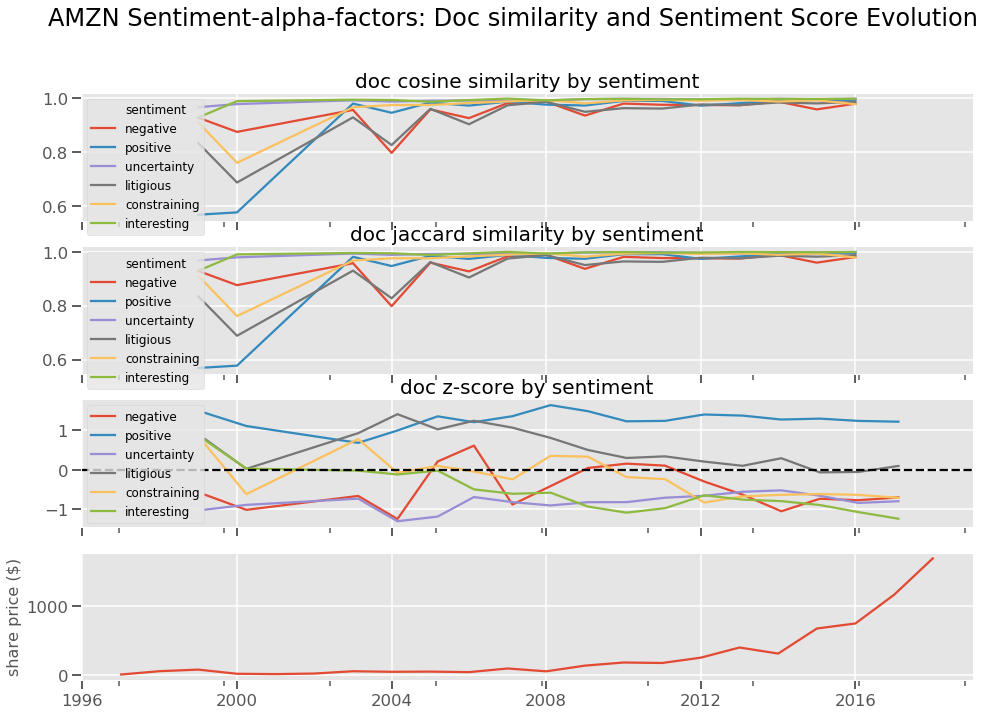

In [43]:
fig, axs = plt.subplots(4,1, sharex=True  , figsize=(16, 12))

plt.suptitle(f'{example_ticker} Sentiment-alpha-factors: Doc similarity and Sentiment Score Evolution')

ax = axs[0]
sns.lineplot(ax=ax, data=cosine_similarities_df[cosine_similarities_df['ticker']==example_ticker],
             x='date', y='value', hue='sentiment')
ax.set_title('doc cosine similarity by sentiment')
ax.set_ylabel('')
ax.legend(loc='upper left')

ax = axs[1]
sns.lineplot(ax=ax, data=jaccard_similarities_df[jaccard_similarities_df['ticker']==example_ticker],
             x='date', y='value', hue='sentiment')
ax.set_title('doc jaccard similarity by sentiment')
ax.set_ylabel('')
ax.legend(loc='upper left')

ax = axs[2]
sent_alphas.xs(level='ticker', key=example_ticker).plot(ax=ax)
ax.set_title('doc z-score by sentiment')
ax.legend(loc='upper left')
ax.axhline(y=0, linestyle='--', color='black')

ax = axs[3]
sns.lineplot(ax=ax, data=pricing[example_ticker])
ax.set_ylabel('share price ($)')
plt.show()

# Compute Doc Sentiment

In [44]:
sentiment_tfidf_ten_ks[example_ticker]['negative'].shape

(17, 1515)

In [45]:
sentiment_tfidf_ten_ks[example_ticker]['litigious'].shape

(17, 716)

In [46]:
sentiment_df

,negative,positive,uncertainty,litigious,constraining,interesting,word
0,True,False,False,False,False,False,abandon
1,True,False,False,False,False,False,abandonment
2,True,False,False,False,False,False,abandonments
3,True,False,False,False,False,False,abdicate
4,True,False,False,False,False,False,abdication
...,...,...,...,...,...,...,...
2714,True,False,False,False,False,False,wrongdoing
2715,True,False,False,False,False,False,wrongdoings
2716,True,False,False,False,False,False,wrongful
2717,True,False,False,False,False,False,wrongfully


# Write Data

In [47]:
cosine_similarities_df = cosine_similarities_df.pivot(index=['ticker', 'date'], columns='sentiment', values='value').sort_index()
cosine_similarities_df.columns.name = ''
pd.concat([cosine_similarities_df.head(2), cosine_similarities_df.tail(2)], axis=0)

constraining  interesting  litigious  negative  positive  \
ticker date                                                                   
AMZN   1999-01-01      0.910507     0.929693   0.834116  0.928592  0.568782   
       2000-01-01      0.761389     0.990078   0.688257  0.875994  0.577385   
HON    2015-01-01      0.992195     0.989735   0.994058  0.981160  0.995151   
       2016-01-01      0.991824     0.978718   0.998136  0.986112  0.995570   

                   uncertainty  
ticker date                     
AMZN   1999-01-01     0.967673  
       2000-01-01     0.979188  
HON    2015-01-01     0.994812  
       2016-01-01     0.991763

In [48]:
cosine_similarities_df.to_csv(OUTPATH + OUTFILE1)
sent_alphas.to_csv(OUTPATH + OUTFILE2)